<a href="https://colab.research.google.com/github/j-mayo/CS231n/blob/main/softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'CS231n/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/CS231n/assignment1/cs231n/datasets
/content/drive/My Drive/CS231n/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.396775
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Initialized W ~= 0, so L ~= sum(log(num_class)) / N = log(num_class) = log(10)  = -log(0.1)* 
*In other words, initialized probability of classifier is 0.1, so L ~= 0.1
(softmax is the probability of class)*



In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.958637 analytic: 0.958637, relative error: 8.062512e-08
numerical: 2.053204 analytic: 2.053204, relative error: 5.631668e-09
numerical: -0.100689 analytic: -0.100689, relative error: 2.076191e-07
numerical: -0.045662 analytic: -0.045662, relative error: 8.976642e-07
numerical: 0.419911 analytic: 0.419911, relative error: 4.623502e-08
numerical: -0.387887 analytic: -0.387887, relative error: 1.152877e-07
numerical: 0.032316 analytic: 0.032316, relative error: 2.562168e-07
numerical: -0.133469 analytic: -0.133469, relative error: 3.194916e-07
numerical: 2.196909 analytic: 2.196909, relative error: 3.721690e-08
numerical: 0.750982 analytic: 0.750982, relative error: 1.060935e-07
numerical: -0.456776 analytic: -0.456776, relative error: 7.420475e-08
numerical: -4.633023 analytic: -4.633023, relative error: 1.677925e-09
numerical: 0.521908 analytic: 0.521908, relative error: 9.814182e-08
numerical: -2.927417 analytic: -2.927417, relative error: 1.614907e-08
numerical: 2.519272 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np

In [8]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.396775e+00 computed in 0.165621s
vectorized loss: 2.396775e+00 computed in 0.018278s
Loss difference: 0.000000
Gradient difference: 0.000000


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = np.arange(1e-7, 5e-5, 5e-6)
regularization_strengths = np.arange(2.5e3, 5e4, 4.75e3)

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=True)
        
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_softmax = softmax
        
        results[(lr, rs)] = (train_accuracy, val_accuracy)
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 82.511813
iteration 100 / 1500: loss 73.382993
iteration 200 / 1500: loss 66.026889
iteration 300 / 1500: loss 59.755847
iteration 400 / 1500: loss 53.994887
iteration 500 / 1500: loss 48.958003
iteration 600 / 1500: loss 44.191025
iteration 700 / 1500: loss 40.237707
iteration 800 / 1500: loss 36.442753
iteration 900 / 1500: loss 33.146157
iteration 1000 / 1500: loss 30.228066
iteration 1100 / 1500: loss 27.361720
iteration 1200 / 1500: loss 24.903573
iteration 1300 / 1500: loss 22.762789
iteration 1400 / 1500: loss 20.677516
iteration 0 / 1500: loss 226.387604
iteration 100 / 1500: loss 168.921298
iteration 200 / 1500: loss 126.501303
iteration 300 / 1500: loss 94.606075
iteration 400 / 1500: loss 71.178172
iteration 500 / 1500: loss 53.577697
iteration 600 / 1500: loss 40.554052
iteration 700 / 1500: loss 30.771094
iteration 800 / 1500: loss 23.435852
iteration 900 / 1500: loss 17.923924
iteration 1000 / 1500: loss 13.978230
iteration 1100 / 1500: loss 10.96

/content/drive/My Drive/CS231n/assignment1/cs231n/classifiers/softmax.py:144: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


iteration 0 / 1500: loss 82.516719
iteration 100 / 1500: loss 15.586025
iteration 200 / 1500: loss 14.824774
iteration 300 / 1500: loss 17.023499
iteration 400 / 1500: loss 16.715899
iteration 500 / 1500: loss 13.274775
iteration 600 / 1500: loss 14.365559
iteration 700 / 1500: loss 15.360068
iteration 800 / 1500: loss 19.570159
iteration 900 / 1500: loss 18.684636
iteration 1000 / 1500: loss 15.774418
iteration 1100 / 1500: loss 18.941955
iteration 1200 / 1500: loss 17.360462
iteration 1300 / 1500: loss 18.068443
iteration 1400 / 1500: loss 18.886042
iteration 0 / 1500: loss 232.229982
iteration 100 / 1500: loss 18.975661
iteration 200 / 1500: loss 19.432746
iteration 300 / 1500: loss 25.595246
iteration 400 / 1500: loss 24.545157
iteration 500 / 1500: loss 24.053125
iteration 600 / 1500: loss 30.818643
iteration 700 / 1500: loss 22.612371
iteration 800 / 1500: loss 28.076314
iteration 900 / 1500: loss 21.555255
iteration 1000 / 1500: loss 22.461576
iteration 1100 / 1500: loss 22.7942

/content/drive/My Drive/CS231n/assignment1/cs231n/classifiers/softmax.py:144: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1390.548734
iteration 100 / 1500: loss 298850610225242382447286307731146501135353119768576.000000
iteration 200 / 1500: loss 61013440849154963062606554396821897074899749956595360107360856640697344274470806947140902393479168.000000
iteration 300 / 1500: loss 12456524554015784065148736182480759218814092325088889277868611054600228112155125224103064663367120991625376056987708814779795946072065271201267712.000000
iteration 400 / 1500: loss 2543128232161441152863282779441402758069874378873993221839645989673600809317040839065606078523899371026860119989892239434425999042851426125911608018164262051187326295000372174776457939744980992.000000
iteration 500 / 1500: loss 5192059131077262424227817010502841869948495022609972369138880689298445972426375827605374118441150149655671502394737397466650057806107263563619061421

/content/drive/My Drive/CS231n/assignment1/cs231n/classifiers/softmax.py:132: RuntimeWarning: overflow encountered in subtract
  L -= np.max(L, axis=1).reshape(-1, 1) # numeric instability...
/content/drive/My Drive/CS231n/assignment1/cs231n/classifiers/softmax.py:147: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W


iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 81.897384
iteration 100 / 1500: loss 21.873933
iteration 200 / 1500: loss 14.158145
iteration 300 / 1500: loss 17.609833
iteration 400 / 1500: loss 22.501826
iteration 500 / 1500: loss 27.225090
iteration 600 / 1500: loss 18.642125
iteration 700 / 1500: loss 17.174971
iteration 800 / 1500: loss 22.030013
iteration 900 / 1500: loss 29.569648
iteration 1000 / 1500: loss 11.191314
iteration 1100 / 1500: loss 22.045953
iteration 1200 / 1500: loss 12.365931
iteration 1300 / 1500: loss 10.988225
iteration 1400 / 1500: loss 21.849853
iteration 0 / 1500: loss 230.533099
iteration 100 / 1500: loss 25.062689
iteration 200 / 1500: loss 25.288238
iteration 300 / 1500: loss 31.202721
iteration 400 / 1500: loss 33.707202
iteration 500 / 1500: loss 23.682917
iteration 600 / 1500: loss 28.648055
iteration 700 / 1500: loss 30.478021
iteration 800 / 1500: loss 23.425595
iteration 900 / 1500: loss 20.385792
iteration

/content/drive/My Drive/CS231n/assignment1/cs231n/classifiers/softmax.py:132: RuntimeWarning: invalid value encountered in subtract
  L -= np.max(L, axis=1).reshape(-1, 1) # numeric instability...


iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 83.184695
iteration 100 / 1500: loss 22.595893
iteration 200 / 1500: loss 15.373243
iteration 300 / 1500: loss 17.331851
iteration 400 / 1500: loss 20.474211
iteration 500 / 1500: loss 15.557711
iteration 600 / 1500: loss 27.684752
iteration 700 / 1500: loss 23.779163
iteration 800 / 1500: loss 24.300351
iteration 900 / 1500: loss 19.545508
iteration 1000 / 1500: loss 17.157470
iteration 1100 / 1500: loss 28.701954
iteration 1200 / 1500: loss 15.186230
iteration 1300 / 1500: loss 18.102048
iteration 1400 / 1500: loss 11.431827
iteration 0 / 1500: loss 228.498743
iteration 100 / 1500: loss 32.306488
iteration 200 / 1500: loss 38.670923
iteration 300 / 1500: loss 59.223041
iteration 400 / 1500: loss 43.925725
iteration 500 / 1500: loss 26.639710
iteration 600 / 1500: loss 36.082990
iteration 700 / 1500: lo

In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.369000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$ SVM에서는 각 datapoint 당 max를 계산해서 더하니 s_j + 1 < s_y_i라면 loss에 변화가 없을 수 있다. 하지만 Softmax에선 sigma(e^s_j) 항에서, 반드시 하나가 추가되고 그 값은 0 이상이므로 값이 변할 수 밖에 없다.
다른 말로, SVM은 일정 성능의 기준을 넘으면 더이상 개선을 하지 않는데(max 함수로 구현됨) Softmax는 확률이 1이 될 때까지 계속해서 성능을 개선한다(확률을 계산함으로써 loss가 무조건적으로 변함)


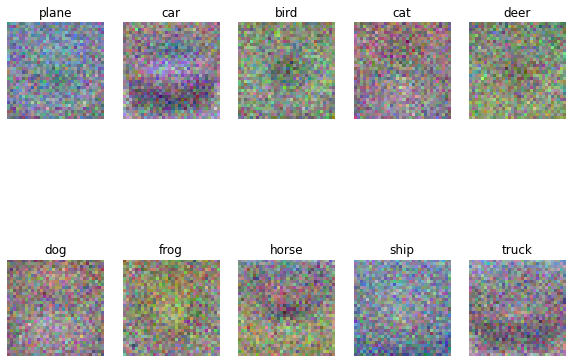

In [11]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])